# Terminal commands for data access

```
autossh -AtX vschuma@ssh1.mdc-berlin.de ssh vschuma@murphy.mdc-berlin.net
# open the ssh screen and/or type
ssh -NR 6667:localhost:22 vfs@79.197.179.128 (current network ID)

# mount
sshfs -p 6667 vschuma@localhost:/data/local/rajewsky/home/vschuma /mnt/murphy_workspace/
or
sshfs vschuma@murphy:/data/local/rajewsky/home/vschuma/ ~/mounts/murphy_workspace/

# if working with the mount is to slow, copy the data to a ramdisk
sudo mount -t tmpfs -o size=6g tmpfs /mnt/ramdisk/

# then copy the file to the ramdisk
mkdir /mnt/ramdisk/data && rsync -av /mnt/murphy_workspace/NSTT/data/GarciaAlsono_uterus/hot_data/* /mnt/ramdisk/data
or
mkdir /dev/shm/data && rsync -av /home/vschuma/mounts/murphy_workspace/NSTT/data/GarciaAlsono_uterus/hot_data/* /dev/shm/data/
# symlink inside the pycharm project to the data dir
(example command)
ln -s /mnt/ramdisk/data data
e.g.: ln -s /mnt/murphy_workspace/NSTT/data/ data
or
ln -s /dev/shm/data/ data
```

# Imports

In [1]:
from importlib import reload

import anndata
from bokeh.layouts import column
%matplotlib inline
import novosparc
import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
# import altair as alt
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
from scipy.stats import zscore
from sklearn import preprocessing

import random

# Notebook location

In [2]:
os.getcwd()

'/home/vschuma/PycharmProjects/novosparc/Vic/development'

# Data read in

I use the mouse brain data set used in [this squidpy tutorial](https://squidpy.readthedocs.io/en/stable/auto_tutorials/tutorial_visium_hne.html#sphx-glr-auto-tutorials-tutorial-visium-hne-py).
The preprocessing (atlas creation, dge and cell type extraction was done in the `data_for_celltype_transfer_tesing` notebook.

## atlas and dge
Note that in this case (bc taken from visium data) there are as many (pseudo) cells as locations.

In [6]:
# atlas settings
atlas_dir = 'data'
target_space_path = os.path.join(atlas_dir, '10x_MouseBrain_coordinates.csv')
locations = pd.read_csv(target_space_path, sep=',')
num_locations = locations.shape[0] # coming from the spatial data #
locations_apriori = locations[:num_locations][['xcoord', 'ycoord']].values
locations = locations_apriori

# if the above creates problems when merging with adata try this one:
# locations_apriori = locations[:num_locations][['xcoord', 'ycoord']]
# locations = np.asarray(locations_apriori)
atlas_path = os.path.join(atlas_dir, 'mouse_brain_test_atlas.csv')
# atlas = sc.read_csv(atlas_path, delimiter=',') # this always through a Value Error about unmatching column numbers - idea why

chunks = pd.read_csv(atlas_path, index_col=0, chunksize=1000000)
df = pd.concat(chunks)
atlas = sc.AnnData(df)
atlas_genes = atlas.var.index.tolist()
print(len(atlas_genes))
print(atlas.shape)
print(locations.shape)
atlas.obsm['spatial'] = locations
# Reading expression data to scanpy AnnData (cells x genes)
data_dir = 'data/'
data_path = os.path.join(data_dir, '10x_MouseBrain_dge.csv')
dataset = sc.read(data_path).T
gene_names = dataset.var.index.tolist()
num_cells, num_genes = dataset.shape
print('number of cells: %d' % num_cells)
print('number of genes: %d' % num_genes)

<ipython-input-6-126ef26f36f4>:17: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  atlas = sc.AnnData(df)
/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


50
(2688, 50)
(2688, 2)
number of cells: 2688
number of genes: 18078


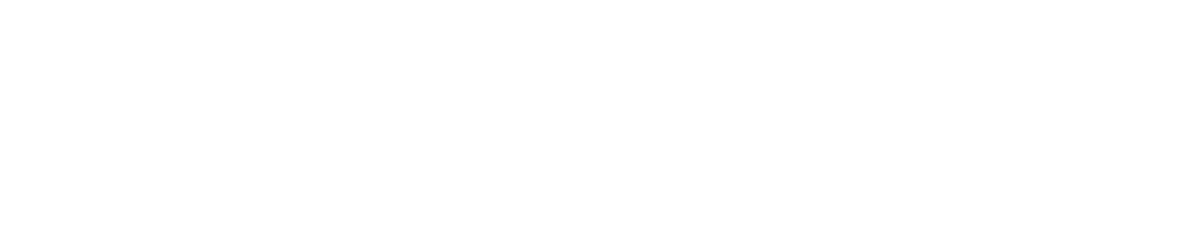

<Figure size 432x288 with 0 Axes>

In [7]:
pl_genes = ["Spock1", "Cacna2d3", "Atp1a3"]
novosparc.pl.embedding(atlas, pl_genes)

## meta data

In [8]:
meta_data_dir = 'data'
meta_ct_path = os.path.join(meta_data_dir, "mouse_brain_meta_ct.csv")

cell_types_raw = pd.read_csv(meta_ct_path)
cell_type = np.asarray(cell_types_raw)
# cell_type

# Reconstruction
## create tissue object

In [9]:
# calculate cost matrix
# params for smooth cost # only needed when/for the part where you don't use the atlas!
num_neighbors_s = num_neighbors_t = 5

# params for linear cost
markers = list(set(atlas_genes).intersection(gene_names))
atlas_matrix = atlas.to_df()[markers].values
markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)

# construct tissue object
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)


# setup smooth
num_neighbors_s = num_neighbors_t = 5

# alternative 1: setup both assumptions
tissue.setup_reconstruction(atlas_matrix=atlas_matrix,
                            markers_to_use=markers_to_use,
                            num_neighbors_s=num_neighbors_s,
                            num_neighbors_t=num_neighbors_t)

# compute optimal transport of cells to locations
alpha_linear = 0.1
epsilon = 5e-3
# tissue.dge = sparse.csr_matrix(tissue.dge)
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

Setting up for reconstruction ... done ( 25.98 seconds )
Reconstructing spatial information with 50 markers: 2688 cells and 2688 locations ... 
Trying with epsilon: 5.00e-03


/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


Trying with epsilon: 5.00e-03


# meta data transfer
## prepare gw matrix

In [10]:
gw_matrix = pd.DataFrame(tissue.gw)
type(gw_matrix)
gw_matrix.shape[0]

2688

# use one-hot encoding

## merge celltype with gw

In [11]:
print(cell_types_raw.shape)
print(gw_matrix.shape)
ct_gw_merge = gw_matrix.join(cell_types_raw)
print(ct_gw_merge.shape)
print(ct_gw_merge[:3])

(2688, 1)
(2688, 2688)
(2688, 2689)
              0             1             2             3             4  \
0  3.059879e-04  1.252706e-09  6.642013e-10  1.043016e-09  1.059758e-08   
1  4.135893e-09  3.242720e-04  3.320424e-10  7.571579e-08  5.764577e-09   
2  5.947184e-09  3.996927e-10  3.014582e-04  1.452021e-09  1.642554e-08   

              5             6             7             8             9  ...  \
0  1.249125e-09  6.725484e-08  2.077757e-07  1.102059e-08  1.041035e-08  ...   
1  1.557981e-08  2.034492e-08  2.700747e-08  1.298598e-09  1.051326e-08  ...   
2  2.109268e-08  3.229459e-08  2.797392e-09  1.100197e-09  7.834444e-08  ...   

           2679          2680          2681          2682          2683  \
0  6.659205e-09  1.857860e-08  1.877083e-10  4.335651e-09  7.949094e-09   
1  2.560378e-09  4.203760e-09  1.438191e-09  2.098866e-08  6.703376e-09   
2  2.154366e-07  8.020407e-08  1.650866e-10  6.448941e-10  1.403917e-09   

           2684          2685          26

## encode cell types

In [12]:
ct_unique = np.unique(cell_type)
print(ct_unique, len(ct_unique))

['Cortex_1' 'Cortex_2' 'Cortex_3' 'Cortex_4' 'Cortex_5' 'Fiber_tract'
 'Hippocampus' 'Hypothalamus_1' 'Hypothalamus_2' 'Lateral_ventricle'
 'Pyramidal_layer' 'Pyramidal_layer_dentate_gyrus' 'Striatum' 'Thalamus_1'
 'Thalamus_2'] 15


In [13]:
onehot = pd.get_dummies(cell_types_raw)

## multiply gw and ct

In [14]:
print(gw_matrix.shape) # cells x locations

ct_gw_merge = np.dot(gw_matrix.T, onehot)
print(ct_gw_merge.shape) # locations x ct

(2688, 2688)
(2688, 15)


## adding the matrix  to the tissue object

In [15]:
ctgw_df = pd.DataFrame(ct_gw_merge, columns=ct_unique)
tissue.ctgw = ctgw_df # celltypes are the columns

# check diversity of gw

In [16]:
tissue.gw[0]

array([3.05987939e-04, 1.25270560e-09, 6.64201340e-10, ...,
       1.43476614e-09, 3.51521147e-08, 1.50595280e-08])

# Plotting

1. per celltype visu: 1 color, mapping probability is encoded by alpha value of the color
2. celltype mixture mapping visu: as many colors as celltypes, every location get's the celltype value with the highest probability value

In [17]:
# ToDo

ct_test = ['Hippocampus','Cortex_3', 'Striatum']
dataset_tissue = sc.AnnData(tissue.ctgw, dtype=float)
dataset_tissue.obsm['spatial'] = locations

/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [18]:
type(locations)

numpy.ndarray

## ct specific
just use the normal novosparc function and give cell types instead of genes

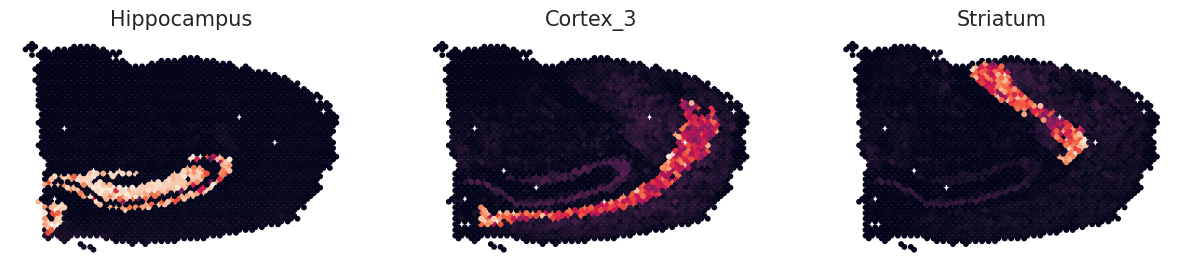

<Figure size 432x288 with 0 Axes>

In [19]:
novosparc.pl.embedding(dataset_tissue, ct_test)

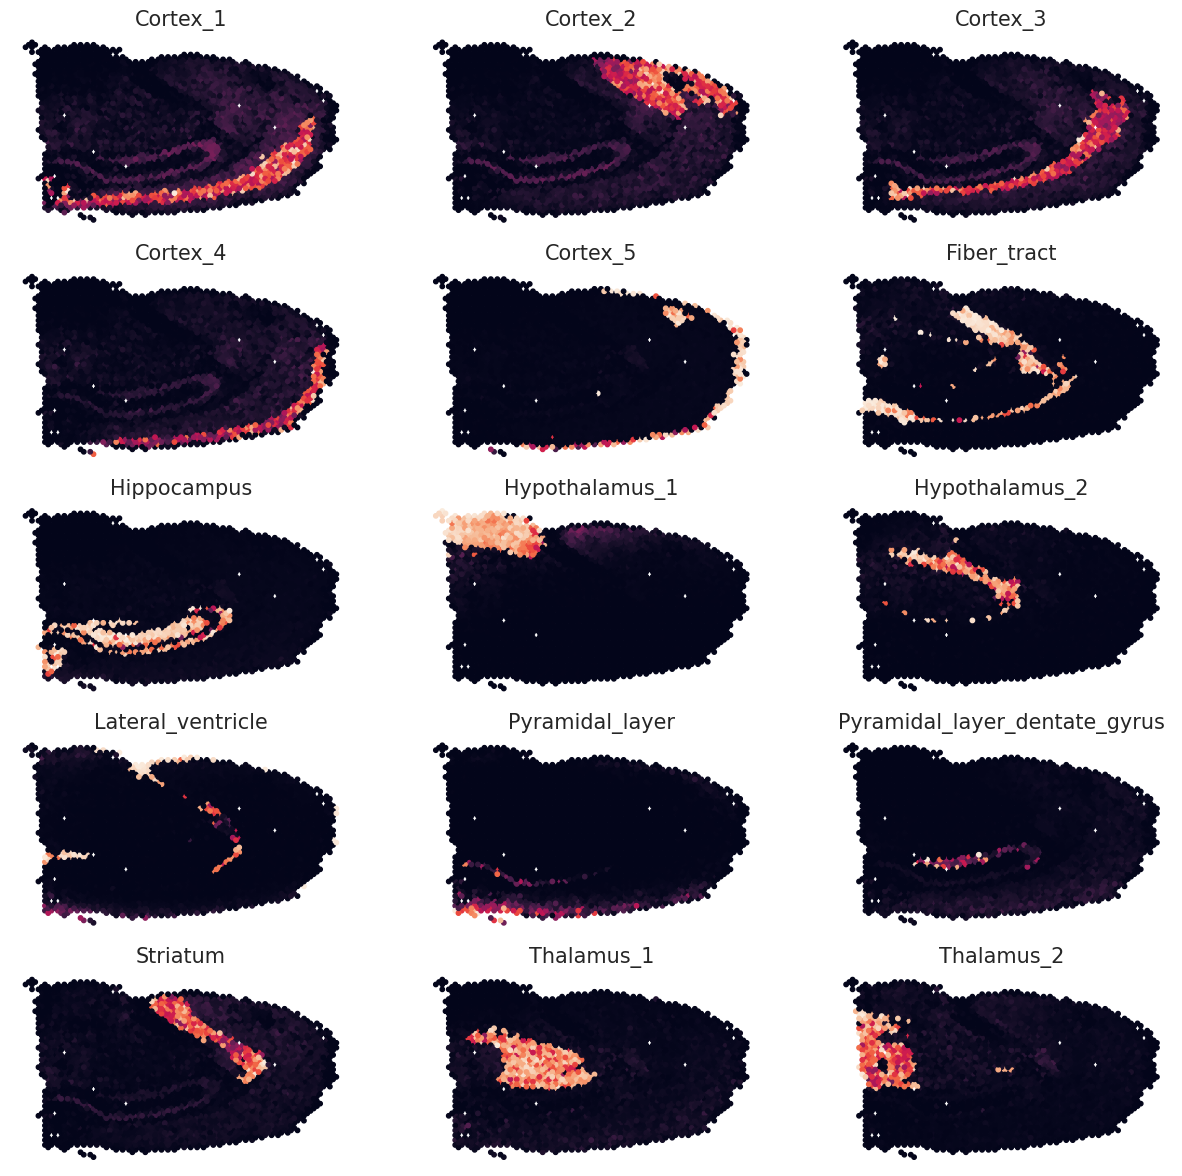

<Figure size 432x288 with 0 Axes>

In [20]:
novosparc.pl.embedding(dataset_tissue, ct_unique)

## Plot all annotations in one plot

1. filter the annotation
with the highest probability per location (maybe the prob value too)

In [21]:
# init a data frame with 2 columns: mapped_ct  & mapping_value
mapped_meta_df = pd.DataFrame(columns=["mapped_ct",
                                       "mapping_value_ct"])
# need to do this in an iterative way later (for multiple meta data classes) would be smth like:
# df = pd.DataFrame(columns=['colname_' + str(i) for i in range(5)])

In [22]:
# loop over tissue.ctgw rowwise

# find max value in the row
out_array = np.amax(np.array(tissue.ctgw), axis=1)
# find the values column name - get the index
out_array = np.vstack((out_array, np.argmax(np.array(tissue.ctgw), axis=1)))

In [23]:

# transform to df to enable multiple data types
out_df = pd.DataFrame(out_array.T)
print(out_df.shape)

(2688, 2)


In [24]:
%%time
# write value and column name into the new df
# can I add a new column like this? - yes, but it takes already quite some time
out_df[2] = out_df[1].apply(lambda x: tissue.ctgw.columns[x])
out_df.columns = ["mapping_prop_ct", "mapped_ct_idx", "mapped_ct"]

<timed exec>:3: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.


CPU times: user 1min 49s, sys: 965 ms, total: 1min 50s
Wall time: 1min 50s


In [25]:
# add annotation to the dataset anndata
# why does adding to obs only creates NA ?
dataset_tissue.obsm["mapped_ct"] = out_df["mapped_ct"].to_numpy().reshape(-1,1)
dataset_tissue.obsm["mapping_prop_ct"] = out_df["mapping_prop_ct"].to_numpy().reshape(-1,1)
dataset_tissue.obsm["mapped_ct_idx"] = out_df["mapped_ct_idx"].to_numpy().reshape(-1,1)

### different ideas for filling a dataframe through a loop
Collections of ways to do it. Would have to test which of them is the fastest and most memory efficant one. I think it makes sense to do this already since those df tend to be quite big.


1. in the loop create a list of list and only later transform that list into a df
```
import pandas as pd
list_of_lists = []
list_of_lists.append([1,2,3])
list_of_lists.append([4,5,6])

pd.DataFrame(list_of_lists, columns=['A', 'B', 'C'])
#    A  B  C
# 0  1  2  3
# 1  4  5  6
```
2. use a simple loop to write into a previously initialized df
```
df = pd.DataFrame(columns=('col1', 'col2', 'col3'))
for i in range(5):
   df.loc[i] = ['<some value for first>','<some value for second>','<some value for third>']`
```
3. create a dict in the loop and concat that into a df
```
df = pd.DataFrame(columns=["firstname", "lastname"])

entry = pd.DataFrame.from_dict({
     "firstname": ["John"],
     "lastname":  ["Johny"]
})

df = pd.concat([df, entry], ignore_index=True)
```
4. do a row by row thing using a series
```
df = pd.DataFrame(columns=['a','b','c','d'], index=['x','y','z'])

df.loc['y'] = pd.Series({'a':1, 'b':5, 'c':2, 'd':3})
```

### Article about speed comparisons of pandas functions
[ --> Architecture & Performance](https://www.architecture-performance.fr/ap_blog/applying-a-row-wise-function-to-a-pandas-dataframe/)

## plot function

In [ ]:
# novosparc plotting function
def embedding(dataset, color, title=None, size_x=None, size_y=None,
                          pt_size=10, tit_size=15, dpi=100):
    """
    Plots fields (color) of Scanpy AnnData object on spatial coordinates
    dataset -- Scanpy AnnData with 'spatial' matrix in obsm containing the spatial coordinates of the tissue
    color -- a list of fields - gene names or columns from obs to use for color
    """

    # set plotting frame with number and size of plots
    title = color if title is None else title
    ncolor = len(color)
    per_row = 3 # Fixme: why is this hardcoded anyway? make it dynamic pls
    per_row = ncolor if ncolor < per_row else per_row
    nrows = int(np.ceil(ncolor / per_row))
    size_x = 5 * per_row if size_x is None else size_x # Fixme: see above
    size_y = 3 * nrows if size_y is None else size_y # Fixme: see above
    fig, axs = plt.subplots(nrows, per_row, figsize=(size_x, size_y), dpi=dpi)
    xy = dataset.obsm['spatial']
    x = xy[:, 0]
    y = xy[:, 1] if xy.shape[1] > 1 else np.ones_like(x)
    axs = axs.flatten() if type(axs) == np.ndarray else [axs]
    for ax in axs:
        ax.axis('off')

    # plot mapped expression values per gene
    for i, g in enumerate(color):
        if g in dataset.var_names:
            values = dataset[:, g].X
        elif g in dataset.obs.columns:
            values = dataset.obs[g]
        else:
            continue
        axs[i].scatter(x, y, c=np.array(values), s=pt_size)
        axs[i].set_title(title[i], size=tit_size)

    plt.show()
    plt.tight_layout()

In [ ]:
xy = dataset_tissue.obsm['spatial']
x = xy[:, 1]
y = xy[:, 0] if xy.shape[1] > 1 else np.ones_like(x)

## all ct together (highest mapping prob only)

In [ ]:
# values = dataset_tissue.obsm["mapped_ct_idx"]

In [ ]:
# group_codes = {k:idx for idx, k in enumerate(out_df.mapped_ct.unique())}
# group_codes

In [ ]:
# size_x = 6
# size_y = 4.5
# fig, axs = plt.subplots(1, 1, figsize=(size_x, size_y), dpi=100)
# axs = axs.flatten() if type(axs) == np.ndarray else [axs]
# for ax in axs:
#     ax.axis('off')
# # ToDo: How do I rotate this so it's correct ?
# scatter = axs[0].scatter(x, y, c=np.array(values), s=10)
# axs[0].set_title("coloring per cell type", size=10)
#
# # this works but I don't know how to get the labels in
# # legend_color = axs[0].legend(*scatter.legend_elements(num=14), title="Cell types")
# # axs[0].add_artist(legend_color)
#
# handles = scatter.legend_elements()[0]
# axs[0].legend(title="Cell types", handles = handles, labels=group_codes.keys())
# plt.show()
# plt.tight_layout()

## Open ToDos

* change the color map
* plot all the cell types to the legend
* I don't think that the numbers are matching the correct number yet
* put the legend next to the figure
* ...

# Try plotly

In [ ]:
import plotly.express as px

In [ ]:
values = dataset_tissue.obsm["mapped_ct"]
plot_df = pd.DataFrame(values, columns=["cell types"])

In [ ]:
fig = px.scatter(plot_df, x=x, y=y, color="cell types",
                 width=1000, height=800)
fig.update_xaxes(showgrid=False, zeroline=False)
fig.update_yaxes(showgrid=False, zeroline=False)
fig.update_layout(plot_bgcolor="black")
fig.show()

# Experiments with plotting
## color + opacity in one plot

In [ ]:
# import plotly.graph_objects as go
# import numpy as np
#
# # Create data
# N = 2688
# x = xy[:, 1]
# y = xy[:, 0] if xy.shape[1] > 1 else np.ones_like(x)
# colors = out_df["mapped_ct_idx"]
#
# # real values
# opac_raw = out_df["mapped_ct_idx"].to_numpy().reshape(-1,1)
# opac_norm = (opac_raw - opac_raw.min()) / (opac_raw.max() - opac_raw.min())
#
# # toy values
# # opac_norm = np.random.uniform(0,1,N)
#
# fig = go.Figure()
# fig.update_xaxes(showgrid=False, zeroline=False)
# fig.update_yaxes(showgrid=False, zeroline=False)
# # fig.update_layout(plot_bgcolor="black")
# fig.layout.height = 800
# fig.layout.width = 1000
#
# fig.add_trace(go.Scatter(
#     x=x,
#     y=y,
#     mode="markers",
#     marker=go.scatter.Marker(
#         color=colors,
#         showscale = True,
#         size=13,
#         opacity=opac_norm,
#         colorscale="Viridis"
#     )
# ))
#
# fig.show()

In [ ]:
# help(go.Scatter)

In [ ]:
# opac_raw = out_df["mapped_ct_idx"].to_numpy().reshape(-1,1)
# opac_norm1 = np.log(opac_raw)
# opac_norm = (opac_norm1 - opac_norm1.min()) / (opac_norm1.max() - opac_norm1.min())


## labels as discrete colors with strings as label

In [138]:
import plotly.graph_objects as go
import plotly.express as px

colors = px.colors.qualitative.Alphabet

# Create data
N = 2688
x = xy[:, 1]
y = xy[:, 0] if xy.shape[1] > 1 else np.ones_like(x)
colors = out_df["mapped_ct_idx"]

# real values
# opac_raw = out_df["mapped_ct_idx"].to_numpy().reshape(-1,1)
# opac_norm = (opac_raw - opac_raw.min()) / (opac_raw.max() - opac_raw.min())

# toy values
opac_norm = np.random.uniform(0,1,N)

fig = go.Figure()
fig.update_xaxes(showgrid=False, zeroline=False)
fig.update_yaxes(showgrid=False, zeroline=False)
# fig.update_layout(plot_bgcolor="black")
fig.layout.height = 800
fig.layout.width = 1000

fig.add_trace(go.Scatter(
    x=x,
    y=y,
    mode="markers",
    text = out_df["mapped_ct"], # todo this could be an array of joint string with cell type + probability
    marker=go.scatter.Marker(
        color=colors,
      #  showscale = True,
        size=13,
        opacity=opac_norm,
        colorscale="Viridis"
    )
))
# fig.update_traces(text=out_df["mapped_ct"], textfont_size=20)

In [139]:
import plotly.graph_objects as go
import pandas as pd

df = pd.DataFrame({'world_rank': [1, 2, 3, 4, 5],
                   'university_name': ['Harvard', 'MIT', 'Stanford', 'Cambridge', 'Oxford'],
                   'citations': [98.8, 98.7, 97.6, 97.5, 96]})

layout = dict(plot_bgcolor='white',
              margin=dict(t=20, l=20, r=20, b=20),
              xaxis=dict(title='World Rank',
                         range=[0.9, 5.5],
                         linecolor='#d9d9d9',
                         showgrid=False,
                         mirror=True),
              yaxis=dict(title='Citations',
                         range=[95.5, 99.5],
                         linecolor='#d9d9d9',
                         showgrid=False,
                         mirror=True))

data = go.Scatter(x=df['world_rank'],
                  y=df['citations'],
                  text=df['university_name'],
                  textposition='top right',
                  textfont=dict(color='#E58606'),
                  mode='lines+markers+text',
                  marker=dict(color='#5D69B1', size=8),
                  line=dict(color='#52BCA3', width=1, dash='dash'),
                  name='citations')

fig = go.Figure(data=data, layout=layout)

fig.show()